# Regression Model
This is the regression model that is trained to predict accurate depth maps (e.g 128,128) from single input RGB images (e.g 512. 512, 3). A set of experiments takes place, in this notebook. In summary:

*   Define X (Input Images) and Y (GT-depth maps) data
*   Select Depth Regression Network Architecture
*   Train Model for a number of initial samples
*   Test on random sample/example




## Dataset
Define the path to the dataset for the input data and the ground truth depth maps. Load everything to the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

input_data_path = '/content/drive/MyDrive/datasets/eg3d/images/' #@param
gt_data_path = '/content/drive/MyDrive/datasets/eg3d/latent/' #@param

Mounted at /content/drive


## Utilities

In [ ]:
# Function to convert a depth image to a mesh 
# Adapted from https://github.com/sfu-gruvi-3dv/deep_human
import PIL
import numpy as np
from tqdm import tqdm
import torch
def depthImage2mesh(img_path, save=False, output_path='/content/drive/MyDrive/eg3d/output/mesh.obj'):
  ''' Convert a depth image to mesh constituents 
    - img_path: string path to depth image (.png)
    return:
    - verts: torch.tensor (B, N, 3), where B for batch size and N for 
    number of vertices
    - faces: torch.tensor (B, F, 3), where B for batch size and F for
     number of faces --> indeces of vertices
    - colors: torch.tensor (B, N, 3), where B for batch size and N for
     number of vertices
  '''
  # Read image and depth values
  img = np.array(PIL.Image.open(img_path))
  #print(img.shape, img.dtype, img[0])
  
  
  # Normalize to depth values in [-1,1] 
  maxx = np.amax(img)
  minx = np.amin(img)
  x = 2 * ((img - minx) / (maxx - minx) ) - 1
  img =  np.array(x, dtype=np.float32)
  depth = -img.copy()
  mask = img.copy()
  mask[mask < 0] = 1

  ## Convert to vertices with depth
  h = depth.shape[0]
  w = depth.shape[1]
  depth = depth.reshape(h,w,1)
  faces = []  # N x 3  number of triangles
  verts = [] # V x 3 number of vertices
  v_strings = [] # strings with vertices for obj
  f_strings = [] # strings with faces for obj
  for i in range(h):
      for j in range(w):
          verts.append( [float(2.0*i/h) , float(2.0*j/w), float(depth[i,j,0])] )
          v_strings.append('v '+str(float(2.0*i/h))+' '+str(float(2.0*j/w))+' '+str(float(depth[i,j,0]))+'\n')

  threshold = 1.5 # adapted for better mesh quality --> the higher the more robust the result
  # no mesh face gaps
  
  
  for i in tqdm(range(h-1)):
      for j in range(w-1):
          if i < 2 or j < 2:
              continue
          localpatch= np.copy(depth[i-1:i+2,j-1:j+2])
          dy_d = localpatch[0, :] - localpatch[1, :]
          dx_l = localpatch[:, 0] - localpatch[:, 1]
          dx_r = localpatch[0 ,:] - localpatch[-1, :]
          dy_u = localpatch[:, 0] - localpatch[:, -1]

          dy_u = np.abs(dy_u)
          dx_l = np.abs(dx_l)
          dy_d = np.abs(dy_d)
          dx_r = np.abs(dx_r)
          if np.max(dy_u)<threshold and np.max(dx_l) < threshold and np.max(dy_d) < threshold and np.max(dx_r) < threshold and mask[i,j]:
              faces.append([int(j+i*w+1), int(j+i*w+1+1), int((i + 1)*w+j+1)])
              faces.append([int((i+1)*w+j+1+1), int((i+1)*w+j+1), int(i * w + j + 1 + 1)])
              # strings for .obj format
              f_strings.append('f '+str(int(j+i*w+1))+' '+str(int(j+i*w+1+1))+' '+str(int((i + 1)*w+j+1))+'\n')
              f_strings.append('f '+str(int((i+1)*w+j+1+1))+' '+str(int((i+1)*w+j+1))+' '+str(int(i * w + j + 1 + 1)) + '\n')

  lim = len(verts) # cannot have valid indeces above this
  safe_faces = []
  for i, fac in enumerate(faces):
    problem = False
    for inds in fac:
      if inds >=lim:
        problem = True
        continue
      else:
        pass
    if not problem:
      safe_faces.append(fac)


  # Save
  f = open(output_path, "w")
  if save:
    for index, v in enumerate(v_strings):
      f.write(v)

    for index, fac in enumerate(f_strings):
      f.write(fac)
  f.close()
    

  verts = torch.from_numpy(np.array(verts)).to(torch.float32).unsqueeze(0)
  faces = torch.from_numpy(np.array(safe_faces)).unsqueeze(0)
  verts_rgb = 0.5* torch.ones_like(verts) # (1, V, 3) # colors



  return verts, faces, verts_rgb

In [ ]:
# Transforms

# Transform latent code
def transform_latent(code):
  ''' This method transforms a 3D latent code (e.g shape (1, 14, 512) ) to a vector (e.g size = 512*14 ) and vice verca'''
  if len(code.shape) < 2:
    code = code.reshape((1, 512, 14))
  if len(code.shape) > 2:
    code = code.reshape(-1)

  return code

In [ ]:
a = torch.zeros((1, 512, 14))
size = a.shape
print(len(size))
c = transform_latent(a)
print(c.shape)

3
torch.Size([7168])


In [ ]:
depth_path = '/content/drive/MyDrive/datasets/eg3d/depth/seed0001.png'
verts, faces, colors = depthImage2mesh(depth_path, save=False)
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 511/511 [00:12<00:00, 39.52it/s]


In [ ]:
!git clone https://github.com/isl-org/MiDaS
!pip install timm

Cloning into 'MiDaS'...
remote: Enumerating objects: 501, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 501 (delta 70), reused 55 (delta 53), pack-reused 408
Receiving objects: 100% (501/501), 414.40 KiB | 13.81 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 15.5 MB/s 


## Unet (modified)

The [UNET](https://github.com/DikshaMeghwal/unet-depth-prediction) architecture is cut in half and appropriate additions of convolutional & pooling layers, costitute the modified UNET leveraged to predict EG3D latent code

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pdb

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


class UNet(nn.Module):
    def __init__(self, init_weights=True):
        super(UNet, self).__init__()                                #572 * 572 * 3 - input
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)                   #570 * 570 * 64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)                  #568 * 568 * 64
                                                                         #after maxpool 284 * 284 * 64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)                 #282 * 282 * 128
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)                #280 * 280 * 128
                                                                         #after maxpool 140 * 140 * 128
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3)                #138 * 138 * 256
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3)                #136 * 136 * 256
                                                                         #after maxpool 68 * 68 * 256
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3)                #66 * 66 * 512
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3)                #64 * 64 * 512
                                                                         #after maxpool 32 * 32 * 512
        self.conv9 = nn.Conv2d(512, 1024, kernel_size=3)               #30 * 30 * 1024
        self.conv10 = nn.Conv2d(1024, 1024, kernel_size=3)             #28 * 28 * 1024

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')      #56 * 56 * 1024  
        self.upConv1 = nn.Conv2d(1024, 512, kernel_size=1)               #56 * 56 * 512
                                                                         #after concatenation with crop of 56 * 56 * 512
                                                                         #56 * 56 * 1024
        self.deConv1 = nn.Conv2d(1024, 512, kernel_size = 3)             #54 * 54 * 512
        #self.conv8                                                      #52 * 52 * 512

        #upsample 1                                                      #104 * 104 * 512
        self.upConv2 = nn.Conv2d(512, 256, kernel_size=1)                #104 * 104 * 256
                                                                         #after concatenation with crop of 104 * 104 * 256
                                                                         #104 * 104 * 512 
        self.deConv2 = nn.Conv2d(512, 256, kernel_size = 3)              #102 * 102 * 256
        #self.conv6                                                      #100 * 100 * 256

        #upsample 1                                                      #200 * 200 * 256
        self.upConv3 = nn.Conv2d(256, 128, kernel_size=1)                #200 * 200 * 128
                                                                         #after concatenation with crop of 200 * 200 * 128
                                                                         #200 * 200 * 256 
        self.deConv3 = nn.Conv2d(256, 128, kernel_size = 3)              #198 * 198 * 128
        #self.conv4                                                      #196 * 196 * 128

        #upsample 1                                                      #392 * 392 * 128
        self.upConv4 = nn.Conv2d(128, 64, kernel_size=1)                 #392 * 392 * 64
                                                                         #after concatenation with crop of 392 * 392 * 64
                                                                         #392 * 392 * 128
        self.deConv4 = nn.Conv2d(128, 64, kernel_size = 3)               #390 * 390 * 64
        #self.conv2                                                      #388 * 388 * 64
        self.deConv5 = nn.Conv2d(64, 1, kernel_size = 1)                 #388 * 388 * 1

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.convX = nn.Conv2d(512, 512, kernel_size=3)                #64 * 64 * 512
        self.deConvX = nn.Conv2d(14, 512, kernel_size = 1)  
        self.finconvX = nn.Conv2d(512, 512, kernel_size=4)
        self.co = nn.Conv2d(512, 512, kernel_size=(2, 4))
        self.co2 = nn.Conv2d(512, 512, kernel_size=(2, 3))
        self.co3 = nn.Conv2d(512, 512, kernel_size=2)

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
                                                                         #H * W * c
                                                                         #572 * 572 * 3
        out1 = F.relu(self.conv1(x))                                     #570 * 570 * 64
        #print('out1:{}'.format(out1.shape))
        out2 = F.relu(self.conv2(out1))                                  #568 * 568 * 64
        #print('out2:{}'.format(out2.shape))
        out3 = self.pool(out2)                                           #284 * 284 * 64   # out of 1st encoder block
        #print('out3:{}'.format(out3.shape))
        out4 = F.relu(self.conv3(out3))                                  #282 * 282 * 128
        #print('out4:{}'.format(out4.shape))
        out5 = F.relu(self.conv4(out4))                                  #280 * 280 * 128
        #print('out5:{}'.format(out5.shape))
        out6 = self.pool(out5)                                           #140 * 140 * 128  # out of 2nd encoder block
        #print('out6:{}'.format(out6.shape))
        out7 = F.relu(self.conv5(out6))                                  #138 * 138 * 256
        #print('out7:{}'.format(out7.shape))
        out8 = F.relu(self.conv6(out7))                                  #136 * 136 * 256
        #print('out8:{}'.format(out8.shape))
        out9 = self.pool(out8)                                           #68 * 68 * 256  # out of 3rd encoder block
        #print('out9:{}'.format(out9.shape))
        out10 = F.relu(self.conv7(out9))                                 #66 * 66 * 512
        #print('out10:{}'.format(out10.shape))
        out11 = F.relu(self.conv8(out10))                                #64 * 64 * 512
        #print('out11:{}'.format(out11.shape))
        out12 = self.pool(out11)                                         #32 * 32 * 512 # out of 4th encoder block
        #print('out12:{}'.format(out12.shape))
        out13 = F.relu(self.conv9(out12))                                #30 * 30 * 1024
        #print('out13:{}'.format(out13.shape))
        out14 = F.relu(self.conv10(out13))                               #28 * 28 * 1024
        #print('out14:{}'.format(out14.shape))

        out15 = self.upsample(out14)                                     #56 * 56 * 1024  
        #print('out15:{}'.format(out15.shape))
        out16 = self.upConv1(out15)                                      #56 * 56 * 512 # 
        #print('out16:{}'.format(out16.shape))
        out17 = self.conv8(out16)
        #print('out17:{}'.format(out17.shape))
        out18 = self.pool(out17)
        #print('out18:{}'.format(out18.shape))                           # output of 1st decoder block 
        out19 = self.co(out18)
        #print('out19:{}'.format(out19.shape))
        #out20 = self.pool(out19)
        out20 = self.co(out19)
        out21 = self.co(out20)
        #print('out12:{}'.format(out20.shape))                          
        out22 = self.co(out21)
        #print('out22:{}'.format(out22.shape))
        out23 = self.co(out22)
        #print('out23:{}'.format(out23.shape))
        out24 = self.co2(out23)
        #print('out24:{}'.format(out24.shape))
        out25 = self.co2(out24)
        #print('out25:{}'.format(out25.shape))
        out26 = self.co2(out25)
        #print('out26:{}'.format(out26.shape))
        out27 = self.co3(out26)
        #print('out26:{}'.format(out27.shape))
        '''
        out16_bypass = out11[:,:,4:52,4:52] # before out16_bypass = out11[:,:,4:60,4:60] 
        #print('out16:{}'.format(out16.shape))
        out17 = torch.cat((out16, out16_bypass), 1)                      #56 * 56 * 1024
        #print('out17:{}'.format(out17.shape))
        out18 = F.relu(self.deConv1(out17))                              #54 * 54 * 512
        #print('out18:{}'.format(out18.shape))
        out19 = F.relu(self.conv8(out18))                                #52 * 52 * 512
        #print('out19:{}'.format(out19.shape))
        out20 = F.relu(self.convX(out19))
        #print('out20:{}'.format(out20.shape))
        out21 = self.pool(out20)
        #print('out21{}'.format(out21.shape))
        out22 = F.relu(self.convX(out21))
        #print('out22{}'.format(out22.shape))
        out23 = F.relu(self.convX(out22))
        #print('out23{}'.format(out23.shape))
        out24 = F.relu(self.finconvX(out23)) [:, :, :, 0]
        '''




        '''

        out20 = self.upsample(out19)                                     #104 * 104 * 512
        #print('out20:{}'.format(out20.shape))
        out21 = self.upConv2(out20)                                      #104 * 104 * 256
        #print('out21:{}'.format(out21.shape))
        #before out21_bypass = out8[:, :, 16:120, 16:120]
        out21_bypass = out8[:, :, 16:104, 16:104]                        #104 * 104 * 256
        #print('out21_bypass:{}'.format(out21_bypass.shape))
        out22 = torch.cat((out21, out21_bypass), 1)                      #104 * 104 * 512 
        #print('out22:{}'.format(out22.shape))
        out23 = F.relu(self.deConv2(out22))                              #102 * 102 * 256
        #print('out23:{}'.format(out23.shape))
        out24 = F.relu(self.conv6(out23))                                #100 * 100 * 256
        #print('out24:{}'.format(out24.shape))

        out25 = self.upsample(out24)                                     #200 * 200 * 256
        #print('out25:{}'.format(out25.shape))
        out26 = self.upConv3(out25)                                      #200 * 200 * 128
        #print('out26:{}'.format(out26.shape))
        # before out26_bypass = out5[:, :, 40:240, 40:240]  
        out26_bypass = out5[:, :, 40:208, 40:208]                        #200 * 200 * 128
        #print('out26_bypass:{}'.format(out26_bypass.shape))
        out27 = torch.cat((out26, out26_bypass), 1)                      #200 * 200 * 256 
        #print('out27:{}'.format(out27.shape))
        out28 = F.relu(self.deConv3(out27))                              #198 * 198 * 128
        #print('out28:{}'.format(out28.shape))
        out29 = F.relu(self.conv4(out28))                                #196 * 196 * 128
        #print('out29:{}'.format(out29.shape))

        
        out30 = self.upsample(out29)                                     #392 * 392 * 128
        #print('out30:{}'.format(out30.shape))
        out31 = self.upConv4(out30)                                      #392 * 392 * 64
        #print('out31:{}'.format(out31.shape))
        # before out31_bypass = out2[:, :, 88:480, 88:480]    
        out31_bypass = out2[:, :, 88:416, 88:416]                        #392 * 392 * 64
        #print('out31_bypass:{}'.format(out31_bypass.shape))
        out32 = torch.cat((out31, out31_bypass), 1)                      #392 * 392 * 128
        #print('out32:{}'.format(out32.shape))
        out33 = self.deConv4(out32)                                      #390 * 390 * 64
        #print('out33:{}'.format(out33.shape))
        out34 = self.conv2(out33)                                        #388 * 388 * 64
        #print('out34:{}'.format(out34.shape))
        out35 = self.deConv5(out34)
        print('out35:{}'.format(out35.shape))                            #388 * 388 * 1
        '''
        return out27
        
    def _initialize_weights(self):
        self.apply(init_weights)


In [ ]:
model = UNet()
model.cuda()
#inp = torch.zeros(1, 3, 512, 512).to(device=device, dtype=torch.float)
#out = model(inp)

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
  (upConv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
  (deConv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
  (upConv2): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (deConv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (upConv3): Conv2d(256, 128, kernel_size=(1, 1),

## Train Model
Create different sets of experiments and train different models with different data and split sets. The experiments are saved in different folders under **./experiments**. Each seperate experiment folder containts a **'.pt'** pytorch checkpoint model weights, a **'train.npy'** and **'test.npy'** numpy files that hold the paths of the training and testing data ( input and grounf truth data paths). The **'train.npy'** file holds a dictionary of arrays that can be accessed using the key **'trainX'** and **'trainY'**. Respectively, to get the paths of the validation data, load the **'val.npy'** and query the 2 arrays using **'valX** and **'valY'** keys.

### Steps
1. Model Architecture
2. Preprocessing
3. Postprocessing
4. Validation/Training dataset split
5. Model Training and save
6. Visualize/Report training in Tensorboard

In [ ]:
%cd /content/MiDaS/
from torchvision.transforms import Compose
from midas.transforms import Resize, NormalizeImage, PrepareForNet
import torch.optim as optim
import torch.nn as nn
import torch
import os
import cv2
import utils
import numpy as np
import PIL
from midas.transforms import Resize, NormalizeImage, PrepareForNet

l1_loss = nn.L1Loss(reduction='mean') # l1-loss
mse = nn.MSELoss(reduction='mean') # mse  (mean squared error) loss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.train() # set in train mode
model.to(device)


# Input Preprocessing
net_w, net_h = 512, 512
resize_mode="minimal"
normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

# Transform input 
transform = Compose(
    [ Resize(net_w, net_h, resize_target=None, keep_aspect_ratio=True, ensure_multiple_of=32,
            resize_method=resize_mode, image_interpolation_method=cv2.INTER_CUBIC,), normalization,PrepareForNet(), ])




lr = 0.1
momentum = 0.9
#optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) # optimizer
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                            patience=10, verbose=True)

#pretrained_modelpath = "/content/drive/MyDrive/eg3d/experiments/VIT_latent_train20000_samples/b1_e100_weights_ckp_27.pt"
#optimizer_path = "/content/drive/MyDrive/eg3d/experiments/VIT_latent_train20000_samples/b1_e100_optimizer_ckp_27.pt"
#model.load_state_dict(torch.load(pretrained_modelpath)) # load the final training weights
#optimizer.load_state_dict(torch.load(optimizer_path)) # load the optimizer state

/content/MiDaS


In [ ]:
### Function to perform validation
import time
def validate(model, X, Y, criterion):
  '''
  X: list that contains batches of input data [N , B], for N - numper of batches
  and B the batch size
  Y: GT data stored as batches of gt data [N , B]
  '''
  flat_valX = np.array(X).reshape(-1)
  flat_valY = np.array(Y).reshape(-1)
  assert len(flat_valX) == len(flat_valY)
  inputs = []
  gts = []
  tot_val = 0
  #start = time.time()
  with torch.no_grad():
    for i in range(0, len(flat_valX)):
        gt_np = np.load(flat_valY[i]).transpose() # bring to appropriate shape
        #gt_np = transform_latent(gt_np) # comment for UNET-modified model
        img = utils.read_image(flat_valX[i])
        img_input = transform({"image": img})["image"]
        input = torch.from_numpy(img_input).to(device).unsqueeze(0)
        gt = torch.tensor(gt_np, requires_grad=True).to(device).unsqueeze(0)
        gts.append(gt)
        inputs.append(input)
        prediction = model(input)
        val_loss = criterion(prediction, gt)
        tot_val = tot_val + val_loss
  return tot_val

In [ ]:
root = '/content/drive/MyDrive/datasets/eg3d/images/'
for img in os.listdir(root):
  if 'Copy' in img:
    delete = os.path.join(root, img)
    !rm -f {delete}
    print(delete)


/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49488.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49487.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49494.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49490.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49486.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49489.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49492.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49491.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49493.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49485.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49478.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49482.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49481.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49483.png
/content/drive/MyDrive/datasets/eg3d/images/Copy of seed49480.png
/content/d

In [ ]:
### Create list with GT and input data paths
batch_size =  1#@param
experiment_name = 'latent_train1000samples' #@param
experiment_root = '/content/drive/MyDrive/eg3d/experiments' #@param
experiment_path = os.path.join(experiment_root, experiment_name)
save_train = os.path.join(experiment_path, 'train.npy')
save_val = os.path.join(experiment_path, 'val.npy')
log_file = os.path.join(experiment_path, 'info.log')
os.makedirs(experiment_path, exist_ok=True)
img_data = []
gt_data = []
for img in sorted(os.listdir(input_data_path)):
  if 'of' not in img:
    filepath = os.path.join(input_data_path, img)
    gt_path = os.path.join(gt_data_path, img).replace('png', 'npy')
    img_data.append(filepath)
    gt_data.append(gt_path)


img_data = [img_data[i:i + batch_size] for i in range(0, len(img_data), batch_size )] 
gt_data = [gt_data[i:i+batch_size] for i in range(0, len(gt_data), batch_size)] 


### Dataset split (Train/Val)
num_samples_train =  1000 #@param
num_samples_val =    10 #@param
limit_train = int(num_samples_train / batch_size) # number of training batches
limit_val = int(num_samples_val / batch_size) # number of validation batches
valX = img_data[0:limit_val] # first n batches
valY = gt_data[0:limit_val]
trainX = img_data[limit_val:limit_train+limit_val]
trainY = gt_data[limit_val:limit_train+limit_val]



np.save(os.path.join(experiment_path,'train.npy'),
        {'trainX': trainX,  'trainY': trainY})
np.save(os.path.join(experiment_path, 'val.npy'),
        {'valX': valX,  'valY': valY})

In [ ]:
### Training Skeleton
from tqdm import tqdm
import logging as lg
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torch
import random
n_epochs =      100#@param
f = open(log_file.replace('log', 'txt'), 'w')
comment = '_e{}b{}lr{}t_samples{}v_samples{}'.format(n_epochs, batch_size, lr,
                                                     num_samples_train, num_samples_val)
f.write(comment) 
writer = SummaryWriter() # Tensorboard writer


for epoch in range(0, n_epochs+1):
    total_loss = 0.0
    random.shuffle(trainX)
    # Save model weights every 100 epochs
    if (epoch % 1) == 0:
      weights_savepath = os.path.join(experiment_path, 
      'b{}_e{}_weights_ckp_{}.pt'.format(batch_size, n_epochs, epoch))
      torch.save(model.state_dict(), weights_savepath)
      torch.save(optimizer.state_dict(), weights_savepath.replace("weights", "optimizer"))
    for i, batch in enumerate(tqdm(trainX, position=0, leave=True)):
      inputs = [] # batch inputs
      gts = [] # batch labels/gt data
      for filepath in batch:
        gt_path = filepath.replace('images', 'latent').replace('png', 'npy')
        gt_np = np.load(gt_path).transpose()
        #gt_np = transform_latent(gt_np) # uncomment for VIT architecture
        img = utils.read_image(filepath) # RGB 3 channles between [0,1]
        img_input = transform({"image": img})["image"] # normalized between [-1,1]
        #plt.imshow(img_input.transpose())
        input = torch.from_numpy(img_input).to(device).unsqueeze(0)
        gt = torch.tensor(gt_np).to(device).unsqueeze(0)
        gts.append(gt)
        inputs.append(input)

      # Convert list to batch tensor
      gts = torch.cat(gts)
      inputs = torch.cat(inputs)

      
      # Per batch loss and update
      predictions = model(inputs)
      #print(predictions.shape, gts.shape)
      pred_np = predictions.detach().cpu().numpy()

      
      loss = mse(gts, predictions) # total loss per batch
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += float(loss) # total average batch loss
    

    
    total_val_loss = validate(model, X=valX, Y=valY, criterion=l1_loss)
    val_loss = total_val_loss / num_samples_val  # average val loss
    training_loss = total_loss / limit_train # average training loss
    log = ' '.join(["e", str(epoch),"- Average L1 loss: %f , Val. loss: %f" %(training_loss,val_loss)])
    # logger.info(log)
    writer.add_scalars("Loss", {'train': training_loss, 'val':val_loss},
                      epoch)
    writer.add_scalar("Loss/train", training_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    print(log)
    f.write(log + '\n')
    f.flush()
    writer.flush()
    lr_scheduler.step(total_loss)


f.close() # stop writing in file
#writer.add_mesh(tag='mesh', vertices=verts, faces=faces, colors=colors)
writer.close() # stop Tensorboard writing

100%|██████████| 1000/1000 [24:09<00:00,  1.45s/it]


e 0 - Average L1 loss: 0.080093 , Val. loss: 0.203848


100%|██████████| 1000/1000 [01:19<00:00, 12.65it/s]


e 1 - Average L1 loss: 0.078387 , Val. loss: 0.203320


100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]


e 2 - Average L1 loss: 0.077111 , Val. loss: 0.203455


100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]


e 3 - Average L1 loss: 0.076187 , Val. loss: 0.198587


100%|██████████| 1000/1000 [01:18<00:00, 12.69it/s]


e 4 - Average L1 loss: 0.075272 , Val. loss: 0.199583


100%|██████████| 1000/1000 [01:19<00:00, 12.58it/s]


e 5 - Average L1 loss: 0.074654 , Val. loss: 0.198796


100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


e 6 - Average L1 loss: 0.073943 , Val. loss: 0.200551


100%|██████████| 1000/1000 [01:19<00:00, 12.57it/s]


e 7 - Average L1 loss: 0.073126 , Val. loss: 0.198066


100%|██████████| 1000/1000 [01:19<00:00, 12.59it/s]


e 8 - Average L1 loss: 0.072345 , Val. loss: 0.197133


100%|██████████| 1000/1000 [01:19<00:00, 12.59it/s]


e 9 - Average L1 loss: 0.071477 , Val. loss: 0.196709


100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]


e 10 - Average L1 loss: 0.070572 , Val. loss: 0.193756


100%|██████████| 1000/1000 [01:18<00:00, 12.69it/s]


e 11 - Average L1 loss: 0.069589 , Val. loss: 0.196568


100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]


e 12 - Average L1 loss: 0.068612 , Val. loss: 0.197888


100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]


e 13 - Average L1 loss: 0.067576 , Val. loss: 0.196138


100%|██████████| 1000/1000 [01:19<00:00, 12.53it/s]


e 14 - Average L1 loss: 0.066488 , Val. loss: 0.193641


100%|██████████| 1000/1000 [01:19<00:00, 12.65it/s]


e 15 - Average L1 loss: 0.065356 , Val. loss: 0.194303


100%|██████████| 1000/1000 [01:19<00:00, 12.53it/s]


e 16 - Average L1 loss: 0.064202 , Val. loss: 0.192200


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


e 17 - Average L1 loss: 0.062836 , Val. loss: 0.194296


100%|██████████| 1000/1000 [01:18<00:00, 12.73it/s]


e 18 - Average L1 loss: 0.061433 , Val. loss: 0.194056


100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s]


e 19 - Average L1 loss: 0.060042 , Val. loss: 0.194399


100%|██████████| 1000/1000 [01:18<00:00, 12.80it/s]


e 20 - Average L1 loss: 0.058321 , Val. loss: 0.196164


100%|██████████| 1000/1000 [01:18<00:00, 12.78it/s]


e 21 - Average L1 loss: 0.056839 , Val. loss: 0.199224


100%|██████████| 1000/1000 [01:17<00:00, 12.85it/s]


e 22 - Average L1 loss: 0.054815 , Val. loss: 0.196815


100%|██████████| 1000/1000 [01:18<00:00, 12.77it/s]


e 23 - Average L1 loss: 0.053100 , Val. loss: 0.193091


100%|██████████| 1000/1000 [01:18<00:00, 12.71it/s]


e 24 - Average L1 loss: 0.050903 , Val. loss: 0.197738


100%|██████████| 1000/1000 [01:18<00:00, 12.78it/s]


e 25 - Average L1 loss: 0.048968 , Val. loss: 0.201795


100%|██████████| 1000/1000 [01:18<00:00, 12.81it/s]


e 26 - Average L1 loss: 0.046874 , Val. loss: 0.199218


100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


e 27 - Average L1 loss: 0.044816 , Val. loss: 0.197970


100%|██████████| 1000/1000 [01:17<00:00, 12.82it/s]


e 28 - Average L1 loss: 0.042621 , Val. loss: 0.197684


100%|██████████| 1000/1000 [01:18<00:00, 12.79it/s]


e 29 - Average L1 loss: 0.040497 , Val. loss: 0.197520


100%|██████████| 1000/1000 [01:18<00:00, 12.78it/s]


e 30 - Average L1 loss: 0.038485 , Val. loss: 0.200757


100%|██████████| 1000/1000 [01:18<00:00, 12.81it/s]


e 31 - Average L1 loss: 0.036607 , Val. loss: 0.201373


100%|██████████| 1000/1000 [01:18<00:00, 12.78it/s]


e 32 - Average L1 loss: 0.034819 , Val. loss: 0.200334


100%|██████████| 1000/1000 [01:18<00:00, 12.79it/s]


e 33 - Average L1 loss: 0.033100 , Val. loss: 0.200099


100%|██████████| 1000/1000 [01:18<00:00, 12.78it/s]


e 34 - Average L1 loss: 0.031181 , Val. loss: 0.199693


100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


e 35 - Average L1 loss: 0.029409 , Val. loss: 0.201222


100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


e 36 - Average L1 loss: 0.027821 , Val. loss: 0.201880


100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


e 37 - Average L1 loss: 0.026298 , Val. loss: 0.201475


100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


e 38 - Average L1 loss: 0.024847 , Val. loss: 0.202328


100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]


e 39 - Average L1 loss: 0.023549 , Val. loss: 0.199461


100%|██████████| 1000/1000 [01:18<00:00, 12.71it/s]


e 40 - Average L1 loss: 0.022400 , Val. loss: 0.201725


100%|██████████| 1000/1000 [01:19<00:00, 12.66it/s]


e 41 - Average L1 loss: 0.021367 , Val. loss: 0.202006


100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


e 42 - Average L1 loss: 0.020112 , Val. loss: 0.203401


100%|██████████| 1000/1000 [01:19<00:00, 12.65it/s]


e 43 - Average L1 loss: 0.019045 , Val. loss: 0.202149


100%|██████████| 1000/1000 [01:18<00:00, 12.73it/s]


e 44 - Average L1 loss: 0.018104 , Val. loss: 0.203411


100%|██████████| 1000/1000 [01:18<00:00, 12.71it/s]


e 45 - Average L1 loss: 0.017083 , Val. loss: 0.205044


100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]


e 46 - Average L1 loss: 0.016367 , Val. loss: 0.203686


100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


e 47 - Average L1 loss: 0.015683 , Val. loss: 0.205321


100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


e 48 - Average L1 loss: 0.014969 , Val. loss: 0.204485


100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


e 49 - Average L1 loss: 0.014168 , Val. loss: 0.204950


100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]


e 50 - Average L1 loss: 0.013533 , Val. loss: 0.205748


100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


e 51 - Average L1 loss: 0.012894 , Val. loss: 0.206294


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


e 52 - Average L1 loss: 0.012293 , Val. loss: 0.204231


100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]


e 53 - Average L1 loss: 0.011802 , Val. loss: 0.206346


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


e 54 - Average L1 loss: 0.011366 , Val. loss: 0.205056


100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


e 55 - Average L1 loss: 0.010839 , Val. loss: 0.204908


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


e 56 - Average L1 loss: 0.010410 , Val. loss: 0.206169


100%|██████████| 1000/1000 [01:19<00:00, 12.59it/s]


e 57 - Average L1 loss: 0.009935 , Val. loss: 0.206522


100%|██████████| 1000/1000 [01:19<00:00, 12.63it/s]


e 58 - Average L1 loss: 0.009596 , Val. loss: 0.205617


100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


e 59 - Average L1 loss: 0.009231 , Val. loss: 0.204967


100%|██████████| 1000/1000 [01:19<00:00, 12.61it/s]


e 60 - Average L1 loss: 0.008837 , Val. loss: 0.204614


100%|██████████| 1000/1000 [01:19<00:00, 12.63it/s]


e 61 - Average L1 loss: 0.008594 , Val. loss: 0.206174


100%|██████████| 1000/1000 [01:19<00:00, 12.59it/s]


e 62 - Average L1 loss: 0.008234 , Val. loss: 0.206946


100%|██████████| 1000/1000 [01:19<00:00, 12.60it/s]


e 63 - Average L1 loss: 0.008052 , Val. loss: 0.207137


100%|██████████| 1000/1000 [01:19<00:00, 12.61it/s]


e 64 - Average L1 loss: 0.007740 , Val. loss: 0.206856


100%|██████████| 1000/1000 [01:19<00:00, 12.63it/s]


e 65 - Average L1 loss: 0.007430 , Val. loss: 0.206575


100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]


e 66 - Average L1 loss: 0.007113 , Val. loss: 0.206432


100%|██████████| 1000/1000 [01:19<00:00, 12.66it/s]


e 67 - Average L1 loss: 0.006851 , Val. loss: 0.206997


100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


e 68 - Average L1 loss: 0.006596 , Val. loss: 0.205594


100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]


e 69 - Average L1 loss: 0.006397 , Val. loss: 0.205943


100%|██████████| 1000/1000 [01:19<00:00, 12.65it/s]


e 70 - Average L1 loss: 0.006231 , Val. loss: 0.207341


100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


e 71 - Average L1 loss: 0.006040 , Val. loss: 0.206462


100%|██████████| 1000/1000 [01:18<00:00, 12.66it/s]


e 72 - Average L1 loss: 0.005876 , Val. loss: 0.206579


100%|██████████| 1000/1000 [01:19<00:00, 12.62it/s]


e 73 - Average L1 loss: 0.005657 , Val. loss: 0.206093


100%|██████████| 1000/1000 [01:19<00:00, 12.66it/s]


e 74 - Average L1 loss: 0.005424 , Val. loss: 0.205646


100%|██████████| 1000/1000 [01:18<00:00, 12.69it/s]


e 75 - Average L1 loss: 0.005304 , Val. loss: 0.207534


100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]


e 76 - Average L1 loss: 0.005099 , Val. loss: 0.207153


100%|██████████| 1000/1000 [01:18<00:00, 12.71it/s]


e 77 - Average L1 loss: 0.004954 , Val. loss: 0.206743


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


e 78 - Average L1 loss: 0.004841 , Val. loss: 0.205726


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


e 79 - Average L1 loss: 0.004706 , Val. loss: 0.206428


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


e 80 - Average L1 loss: 0.004599 , Val. loss: 0.206927


100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s]


e 81 - Average L1 loss: 0.004486 , Val. loss: 0.207069


100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


e 82 - Average L1 loss: 0.004327 , Val. loss: 0.206757


100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


e 83 - Average L1 loss: 0.004237 , Val. loss: 0.206486


100%|██████████| 1000/1000 [01:18<00:00, 12.71it/s]


e 84 - Average L1 loss: 0.004136 , Val. loss: 0.207373


100%|██████████| 1000/1000 [01:18<00:00, 12.69it/s]


e 85 - Average L1 loss: 0.004013 , Val. loss: 0.207121


100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]


e 86 - Average L1 loss: 0.003928 , Val. loss: 0.207009


100%|██████████| 1000/1000 [01:19<00:00, 12.66it/s]


e 87 - Average L1 loss: 0.003798 , Val. loss: 0.206839


100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]


e 88 - Average L1 loss: 0.003714 , Val. loss: 0.206638


100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]


e 89 - Average L1 loss: 0.003612 , Val. loss: 0.206346


100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


e 90 - Average L1 loss: 0.003523 , Val. loss: 0.206739


100%|██████████| 1000/1000 [01:18<00:00, 12.66it/s]


e 91 - Average L1 loss: 0.003440 , Val. loss: 0.206546


100%|██████████| 1000/1000 [01:18<00:00, 12.70it/s]


e 92 - Average L1 loss: 0.003338 , Val. loss: 0.207600


100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


e 93 - Average L1 loss: 0.003244 , Val. loss: 0.206185


100%|██████████| 1000/1000 [01:18<00:00, 12.69it/s]


e 94 - Average L1 loss: 0.003152 , Val. loss: 0.206022


100%|██████████| 1000/1000 [01:18<00:00, 12.68it/s]


e 95 - Average L1 loss: 0.003069 , Val. loss: 0.206311


100%|██████████| 1000/1000 [01:18<00:00, 12.66it/s]


e 96 - Average L1 loss: 0.002993 , Val. loss: 0.206076


100%|██████████| 1000/1000 [01:19<00:00, 12.62it/s]


e 97 - Average L1 loss: 0.002920 , Val. loss: 0.206083


100%|██████████| 1000/1000 [01:18<00:00, 12.66it/s]


e 98 - Average L1 loss: 0.002862 , Val. loss: 0.205852


100%|██████████| 1000/1000 [01:18<00:00, 12.69it/s]


e 99 - Average L1 loss: 0.002807 , Val. loss: 0.206862


100%|██████████| 1000/1000 [01:18<00:00, 12.67it/s]


e 100 - Average L1 loss: 0.002739 , Val. loss: 0.207106


In [ ]:
# Save model weights
torch.save(model.state_dict(), weights_savepath)

In [ ]:
# Run Tensorboard locally
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# Upload Tensorboard  analytics to .dev
!tensorboard dev upload --logdir runs \
--name {experiment_name} \
--description "Simple check up test"

## Test Model
Input an RGB single-view image of a human face and predict the EG3D latent code (style vector).All latent code predictions can be reproduced/synthesized (via EG3D) to the respective images using [this notebook](https://colab.research.google.com/drive/1rILRjSyH_TPyk4Jhf6xHneU7DxZvskZv?usp=sharing)

In [ ]:
#@markdown Create and save list of image paths $ \to\ $ '/content/val.npy'
paths = []
path = '/content/drive/MyDrive/datasets/FFHQ/00000/'
for img_path in os.listdir(path):
  if ('.jpg' in img_path) or ('.png' in img_path):
    fullpath = os.path.join(path, img_path)
    paths.append(fullpath)

  if len(paths) > 2:
    break 

np.save('/content/val.npy', {'valX': paths})
#np.save('/content/val.npy', paths)

In [ ]:
### Evaluate model
"""Compute depth maps for images in the input folder.
"""
%cd /content/MiDaS
from torchvision.transforms import Compose
from midas.dpt_depth import DPTDepthModel
from midas.transforms import Resize, NormalizeImage, PrepareForNet
import torch.optim as optim
import torch.nn as nn
import torch
import os
import cv2
import utils
import numpy as np
import PIL
from midas.transforms import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose

model_path =  "/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/b1_e100_weights_ckp_87.pt" #@param {type: "string"}
img_path = '/content/drive/MyDrive/datasets/eg3d/images/seed48495.png' #@param {type: "string"}
#@markdown or give a path to a list of images
img_list_path = "/content/val.npy" #@param {type: "string"}
save = True #@param {type:"boolean"}
output_root = '/content/' #@param {type: "string"}


# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: %s" % device)


net_w, net_h =  512, 512
normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# Input preprocessingg
transform = Compose(
    [
        Resize(
            net_w,
            net_h,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method='minimal',
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        normalization,
        PrepareForNet(),
    ]
)

model.eval()
model.to(device)

try:
  img_list = np.load(img_list_path, allow_pickle=True).item()['valX']
except:
  try:
    img_list = np.load(img_list_path, allow_pickle=True)
  except:
    print('Img path list is not used or wrong path/format')
    img_list = [[img_path], ]


# get input
with torch.no_grad():
  for img_path in img_list:
    img = utils.read_image(img_path) 
    img_input = transform({"image": img})["image"]
    input = torch.from_numpy(img_input).to(device).unsqueeze(0)
    prediction = model(input)
    prediction = prediction.squeeze().detach().cpu().numpy().transpose() # convert to (1, 14, 512)
    img_name = 'out'
    example = img_path.split('/')[-1].split('.')[0] # name of sample
    os.makedirs(os.path.join(output_root, example), exist_ok=True)
    filename = os.path.join(
    os.path.join(output_root,example), os.path.splitext(os.path.basename(img_name))[0])
    output_path = filename + '.png'
    npy_savepath = filename + '.npy'
    #save input image
    if save:
      PIL.Image.open(img_path).save(output_path.replace('out', 'input'))
      # save latent code
      prediction = np.expand_dims(prediction, axis=0)
      np.save(npy_savepath, prediction)
    

print("finished")

/content/MiDaS
device: cuda
finished


## Model Evaluation
To evaluate the model on unseen data, the **mean l1-loss** is used as an evaluation metric. For proper evaluation, paths to both the **input image** and corresponding **gt latent code**, are required. All latent code predictions can be reproduced/synthesized (via EG3D) to the respective images using [this notebook](https://colab.research.google.com/drive/1rILRjSyH_TPyk4Jhf6xHneU7DxZvskZv?usp=sharing)

In [ ]:
#@markdown Save your img files and gt latent code $ \to\ $ '/content/val.npy' and '/content/val_gt.npy'
import os
paths = [] # image paths
gt_paths = []
#path = '/content/drive/MyDrive/datasets/FFHQ/00000/'
path = '/content/drive/MyDrive/datasets/eg3d/images'
path = '/content/drive/MyDrive/datasets/prosopo_new/input/'



for i, img_path in enumerate(sorted(os.listdir(path), reverse=False)):
  if i >=0:
    fullpath = os.path.join(path, img_path)
    paths.append(fullpath)
    #gt_paths.append(fullpath.replace('images', 'latent').replace('png', 'npy'))
    gt_paths.append(fullpath.replace('input', 'latent').replace('png', 'npy'))

  if len(paths) > 1800:
    break
    
'''
paths = []
gt_paths = []
for i in range(47800, 49400):
  fullpath = os.path.join(path, f'seed{i:04d}.png')
  paths.append(fullpath)
  gt_paths.append(fullpath.replace('images', 'latent').replace('png', 'npy'))
'''

np.save('/content/val.npy', paths)
np.save('/content/val_gt.npy', gt_paths)
print(paths)
print("Validation set ---> {} samples".format(len(paths)))

['/content/drive/MyDrive/datasets/prosopo_new/input/00002.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00003.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00004.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00005.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00006.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00007.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00008.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00009.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00014.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00015.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00018.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00019.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00020.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00021.png', '/content/drive/MyDrive/datasets/prosopo_new/input/00022.png', '/content/drive/MyDrive/datasets/prosopo_new/input/000

In [ ]:
### Evaluate model
"""Compute depth maps for images in the input folder.
"""
%cd /content/MiDaS
from torchvision.transforms import Compose
from midas.dpt_depth import DPTDepthModel
from midas.transforms import Resize, NormalizeImage, PrepareForNet
import torch.optim as optim
import torch.nn as nn
import torch
import os
import cv2
import utils
import numpy as np
import PIL
from tqdm import tqdm
from midas.transforms import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose
from midas.dpt_depth import DPTDepthModel
from midas.midas_net import MidasNet
from midas.midas_net_custom import MidasNet_small
from midas.transforms import Resize, NormalizeImage, PrepareForNet
from matplotlib import pyplot as plt

model_path =  "/content/drive/MyDrive/eg3d/experiments/latent_train48000_samples/b1_e100_weights_ckp_9.pt"#@param {type: "string"}
img_path = '/content/drive/MyDrive/datasets/prosopo/input/mein/monalisa.jpg' #@param {type: "string"}
gt_path = '/content/drive/MyDrive/datasets/prosopo/input/mein/monalisa_gt.jpg' #@param {type: "string"}
#@markdown or give a path to a list of images
img_list_path = "/content/val.npy" #@param {type: "string"}
gt_list_path = "/content/val_gt.npy" #@param {type: "string"}
#output_root = '/content/drive/MyDrive/eg3d/output/' 
output_root = '/'.join(model_path.split('/')[:-1])
#@markdown Save results?
save = False #@param {type:"boolean"}



# Transform input
normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = Compose(
    [ Resize(512, 512, resize_target=None, keep_aspect_ratio=True, ensure_multiple_of=32,
            resize_method='minimal', image_interpolation_method=cv2.INTER_CUBIC,), normalization,PrepareForNet(), ])

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: %s" % device)

# load network
try:
  model.load_state_dict(torch.load(model_path, map_location=device)) #model architeture is selected above
  model.eval()
  model.to(device)
except:
  raise Exception('Model architecture and model weights did not match! Are you using the corrrect model?')


try:
  image_paths = np.load(img_list_path, allow_pickle=True)
  gt_paths = np.load(gt_list_path, allow_pickle=True)
except:
    try:
      image_paths = np.load(img_list_path, allow_pickle=True).item()['valX']
      gt_paths = np.load(img_list_path, allow_pickle=True).item()['valY']
    except:
      image_paths = [img_path, ]
      gt_paths = [gt_path, ]


l1_loss = nn.L1Loss(reduction='mean') # l1-loss
testX = np.array(image_paths).reshape( len(image_paths), 1)
testY = np.array(gt_paths).reshape( len(gt_paths), 1)
try:
  tot_loss = validate(model=model, X=testX, Y=testY, criterion=l1_loss)
  print("Mean L1-loss is:", tot_loss.item()/len(testX))
except:
  print("Not enough GPU memory to vaidate on large batch size")





# counter for perfect results
perfect = 0 
tot_loss = 0



with torch.no_grad():
  for i in tqdm(range(len(image_paths))):
    img = utils.read_image(image_paths[i]) 
    img_input = transform({"image": img})["image"]
    input = torch.from_numpy(img_input).to(device).unsqueeze(0)
    prediction = model(input)
    # get current gt and img path
    img_path = image_paths[i]
    gt_path = gt_paths[i]
    prediction_np = prediction.squeeze().cpu().numpy().transpose() # convert to (1, 14, 512)
    
    # gt
    gt_np = np.load(gt_path, allow_pickle=True).transpose()
    #gt_np = transform_latent(gt_np) # comment for UNET-modified model
    gt = torch.tensor(gt_np, requires_grad=True).to(device).unsqueeze(0)
    img_name = 'out'
    #filename = os.path.join(
    #os.path.join(output_root,example), os.path.splitext(os.path.basename(img_name))[0])
    #output_path = filename + '.png'
    sample_loss = l1_loss(prediction, gt)
    if sample_loss < 0.20:
      perfect = perfect + 1
      print(f'Sample loss ({i})', sample_loss.item())
    tot_loss = tot_loss + sample_loss

    if save:
      os.makedirs(os.path.join(output_root, example), exist_ok=True)
      #save input image
      PIL.Image.open(img_path).save(output_path.replace('out', 'input'))
      # save gt depth map
      PIL.Image.open(gt_path).save(output_path.replace('out', 'gt'))
      plt.imshow(prediction_np) # display prediction
      utils.write_depth(filename, prediction_np, bits=1) # save prediction

      pred_mesh_output = filename + '.obj'
      gt_mesh_output = os.path.splitext(pred_mesh_output)[0]+'_gt.obj'
      ### Save .obj
      try:
        verts, faces, colors = depthImage2mesh(img_path=output_path, output_path=pred_mesh_output, save=True)
        print('Pred. obj is saved under:', pred_mesh_output)
      except:
        print("Cannot reconstruct predicted depth map")
      try:
        verts, faces, colors = depthImage2mesh(img_path=gt_path, output_path=gt_mesh_output, save=True)
        print('GT obj is saved under:   ', gt_mesh_output)
      except:
        print("Cannot reconstruct GT depth map")

print('\n', "Perfects:", perfect, "Out of:", len(image_paths))
print('\n', "Total loss:  {}".format(tot_loss/i))


/content/MiDaS
device: cuda
Mean L1-loss is: 0.284825439453125


100%|██████████| 1600/1600 [01:06<00:00, 23.92it/s]


 Perfects: 0 Out of: 1600

 Total loss:  0.28500357270240784


In [ ]:
### Evaluate model
"""Compute depth maps for images in the input folder.
"""
%cd /content/MiDaS
from torchvision.transforms import Compose
from midas.dpt_depth import DPTDepthModel
from midas.transforms import Resize, NormalizeImage, PrepareForNet
import torch.optim as optim
import torch.nn as nn
import torch
import os
import cv2
import utils
import numpy as np
import PIL
from tqdm import tqdm
from midas.transforms import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose
from midas.dpt_depth import DPTDepthModel
from midas.midas_net import MidasNet
from midas.midas_net_custom import MidasNet_small
from midas.transforms import Resize, NormalizeImage, PrepareForNet
from matplotlib import pyplot as plt

l1_loss = nn.L1Loss(reduction='mean') # l1-loss
img_path = '/content/drive/MyDrive/datasets/prosopo/input/mein/monalisa.jpg' #@param {type: "string"}
gt_path = '/content/drive/MyDrive/datasets/prosopo/input/mein/monalisa_gt.jpg' #@param {type: "string"}
#@markdown or give a path to a list of images
img_list_path = "/content/val.npy" #@param {type: "string"}
gt_list_path = "/content/val_gt.npy" #@param {type: "string"}
#output_root = '/content/drive/MyDrive/eg3d/output/' 
output_root = '/'.join(model_path.split('/')[:-1])
#@markdown Save results?
save = False #@param {type:"boolean"}



# Transform input
normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = Compose(
    [ Resize(512, 512, resize_target=None, keep_aspect_ratio=True, ensure_multiple_of=32,
            resize_method='minimal', image_interpolation_method=cv2.INTER_CUBIC,), normalization,PrepareForNet(), ])

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: %s" % device)




try:
  image_paths = np.load(img_list_path, allow_pickle=True)
  gt_paths = np.load(gt_list_path, allow_pickle=True)
except:
    try:
      image_paths = np.load(img_list_path, allow_pickle=True).item()['valX']
      gt_paths = np.load(img_list_path, allow_pickle=True).item()['valY']
    except:
      image_paths = [img_path, ]
      gt_paths = [gt_path, ]




for ckp in range(0,9):
  # counter for perfect results
  perfect = 0 
  tot_loss = 0
  model_path =  f"/content/drive/MyDrive/eg3d/experiments/latent_train48000_samples/b1_e100_weights_ckp_{ckp}.pt"#@param {type: "string"}
  model.load_state_dict(torch.load(model_path, map_location=device)) #model architeture is selected above
  model.eval()
  model.to(device)
  



  with torch.no_grad():
    for i in tqdm(range(len(image_paths))):
      img = utils.read_image(image_paths[i]) 
      img_input = transform({"image": img})["image"]
      input = torch.from_numpy(img_input).to(device).unsqueeze(0)
      prediction = model(input)
      # get current gt and img path
      img_path = image_paths[i]
      gt_path = gt_paths[i]
      prediction_np = prediction.squeeze().cpu().numpy().transpose() # convert to (1, 14, 512)
      
      # gt
      gt_np = np.load(gt_path, allow_pickle=True).transpose()
      #gt_np = transform_latent(gt_np) # comment for UNET-modified model
      gt = torch.tensor(gt_np, requires_grad=True).to(device).unsqueeze(0)
      img_name = 'out'
      #filename = os.path.join(
      #os.path.join(output_root,example), os.path.splitext(os.path.basename(img_name))[0])
      #output_path = filename + '.png'
      sample_loss = l1_loss(prediction, gt)
      if sample_loss < 0.20:
        perfect = perfect + 1
        #print(f'Sample loss ({i})', sample_loss.item())
      tot_loss = tot_loss + sample_loss

      if save:
        os.makedirs(os.path.join(output_root, example), exist_ok=True)
        #save input image
        PIL.Image.open(img_path).save(output_path.replace('out', 'input'))
        # save gt depth map
        PIL.Image.open(gt_path).save(output_path.replace('out', 'gt'))
        plt.imshow(prediction_np) # display prediction
        utils.write_depth(filename, prediction_np, bits=1) # save prediction

        pred_mesh_output = filename + '.obj'
        gt_mesh_output = os.path.splitext(pred_mesh_output)[0]+'_gt.obj'
        ### Save .obj
        try:
          verts, faces, colors = depthImage2mesh(img_path=output_path, output_path=pred_mesh_output, save=True)
          print('Pred. obj is saved under:', pred_mesh_output)
        except:
          print("Cannot reconstruct predicted depth map")
        try:
          verts, faces, colors = depthImage2mesh(img_path=gt_path, output_path=gt_mesh_output, save=True)
          print('GT obj is saved under:   ', gt_mesh_output)
        except:
          print("Cannot reconstruct GT depth map")

  print('\n', "Perfects:", perfect, "Out of:", len(image_paths))
  print('\n', "Total loss for {}:  {}".format(ckp, tot_loss/i))



/content/MiDaS
device: cuda


100%|██████████| 1600/1600 [01:07<00:00, 23.83it/s]



 Perfects: 0 Out of: 1600

 Total loss for 0:  0.27288442850112915


100%|██████████| 1600/1600 [01:06<00:00, 23.90it/s]



 Perfects: 0 Out of: 1600

 Total loss for 1:  0.27693793177604675


100%|██████████| 1600/1600 [01:07<00:00, 23.87it/s]



 Perfects: 0 Out of: 1600

 Total loss for 2:  0.2780505120754242


100%|██████████| 1600/1600 [01:06<00:00, 23.96it/s]



 Perfects: 0 Out of: 1600

 Total loss for 3:  0.28007155656814575


100%|██████████| 1600/1600 [01:06<00:00, 24.08it/s]



 Perfects: 0 Out of: 1600

 Total loss for 4:  0.2806733250617981


100%|██████████| 1600/1600 [01:05<00:00, 24.28it/s]



 Perfects: 0 Out of: 1600

 Total loss for 5:  0.280961811542511


100%|██████████| 1600/1600 [01:05<00:00, 24.34it/s]



 Perfects: 0 Out of: 1600

 Total loss for 6:  0.2814834713935852


100%|██████████| 1600/1600 [01:05<00:00, 24.34it/s]



 Perfects: 0 Out of: 1600

 Total loss for 7:  0.2844175100326538


100%|██████████| 1600/1600 [01:05<00:00, 24.40it/s]


 Perfects: 0 Out of: 1600

 Total loss for 8:  0.2823777198791504


In [ ]:

for ckp in range(0,4):
  # counter for perfect results
  perfect = 0 
  tot_loss = 0
  model_path =  f"/content/drive/MyDrive/eg3d/experiments/latent_train30000_samples/b1_e10_weights_ckp_{ckp}.pt"#@param {type: "string"}
  model.load_state_dict(torch.load(model_path, map_location=device)) #model architeture is selected above
  model.eval()
  model.to(device) 
  with torch.no_grad():
    for i in tqdm(range(len(image_paths))):
      img = utils.read_image(image_paths[i]) 
      img_input = transform({"image": img})["image"]
      input = torch.from_numpy(img_input).to(device).unsqueeze(0)
      prediction = model(input)
      # get current gt and img path
      img_path = image_paths[i]
      gt_path = gt_paths[i]
      prediction_np = prediction.squeeze().cpu().numpy().transpose() # convert to (1, 14, 512)
      
      # gt
      gt_np = np.load(gt_path, allow_pickle=True).transpose()
      #gt_np = transform_latent(gt_np) # comment for UNET-modified model
      gt = torch.tensor(gt_np, requires_grad=True).to(device).unsqueeze(0)
      img_name = 'out'
      #filename = os.path.join(
      #os.path.join(output_root,example), os.path.splitext(os.path.basename(img_name))[0])
      #output_path = filename + '.png'
      sample_loss = l1_loss(prediction, gt)
      if sample_loss < 0.20:
        perfect = perfect + 1
        print(f'Sample loss ({i})', sample_loss.item())
      tot_loss = tot_loss + sample_loss

      if save:
        os.makedirs(os.path.join(output_root, example), exist_ok=True)
        #save input image
        PIL.Image.open(img_path).save(output_path.replace('out', 'input'))
        # save gt depth map
        PIL.Image.open(gt_path).save(output_path.replace('out', 'gt'))
        plt.imshow(prediction_np) # display prediction
        utils.write_depth(filename, prediction_np, bits=1) # save prediction

        pred_mesh_output = filename + '.obj'
        gt_mesh_output = os.path.splitext(pred_mesh_output)[0]+'_gt.obj'
        ### Save .obj
        try:
          verts, faces, colors = depthImage2mesh(img_path=output_path, output_path=pred_mesh_output, save=True)
          print('Pred. obj is saved under:', pred_mesh_output)
        except:
          print("Cannot reconstruct predicted depth map")
        try:
          verts, faces, colors = depthImage2mesh(img_path=gt_path, output_path=gt_mesh_output, save=True)
          print('GT obj is saved under:   ', gt_mesh_output)
        except:
          print("Cannot reconstruct GT depth map")

  print('\n', "Perfects:", perfect, "Out of:", len(image_paths))
  print('\n', "Total loss for {}:  {}".format(ckp, tot_loss/i))



100%|██████████| 1600/1600 [01:03<00:00, 25.36it/s]



 Perfects: 0 Out of: 1600

 Total loss for 0:  0.3329582214355469


100%|██████████| 1600/1600 [01:02<00:00, 25.65it/s]



 Perfects: 0 Out of: 1600

 Total loss for 1:  0.27804476022720337


100%|██████████| 1600/1600 [01:02<00:00, 25.47it/s]



 Perfects: 0 Out of: 1600

 Total loss for 2:  0.28112825751304626


100%|██████████| 1600/1600 [01:02<00:00, 25.53it/s]


 Perfects: 0 Out of: 1600

 Total loss for 3:  0.2828274667263031


In [ ]:

for ckp in range(0,100):
  # counter for perfect results
  perfect = 0 
  tot_loss = 0
  try:
    model_path =  f"/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/b1_e100_weights_ckp_{ckp}.pt"#@param {type: "string"}
    model.load_state_dict(torch.load(model_path, map_location=device)) #model architeture is selected above
    model.eval()
    model.to(device)
  except:
    continue
  with torch.no_grad():
    for i in tqdm(range(len(image_paths))):
      img = utils.read_image(image_paths[i]) 
      img_input = transform({"image": img})["image"]
      input = torch.from_numpy(img_input).to(device).unsqueeze(0)
      prediction = model(input)
      # get current gt and img path
      img_path = image_paths[i]
      gt_path = gt_paths[i]
      prediction_np = prediction.squeeze().cpu().numpy().transpose() # convert to (1, 14, 512)
      
      # gt
      gt_np = np.load(gt_path, allow_pickle=True).transpose()
      #gt_np = transform_latent(gt_np) # comment for UNET-modified model
      gt = torch.tensor(gt_np, requires_grad=True).to(device).unsqueeze(0)
      img_name = 'out'
      #filename = os.path.join(
      #os.path.join(output_root,example), os.path.splitext(os.path.basename(img_name))[0])
      #output_path = filename + '.png'
      sample_loss = l1_loss(prediction, gt)
      if sample_loss < 0.20:
        perfect = perfect + 1
        print(f'Sample loss ({i})', sample_loss.item())
      tot_loss = tot_loss + sample_loss

      if save:
        os.makedirs(os.path.join(output_root, example), exist_ok=True)
        #save input image
        PIL.Image.open(img_path).save(output_path.replace('out', 'input'))
        # save gt depth map
        PIL.Image.open(gt_path).save(output_path.replace('out', 'gt'))
        plt.imshow(prediction_np) # display prediction
        utils.write_depth(filename, prediction_np, bits=1) # save prediction

        pred_mesh_output = filename + '.obj'
        gt_mesh_output = os.path.splitext(pred_mesh_output)[0]+'_gt.obj'
        ### Save .obj
        try:
          verts, faces, colors = depthImage2mesh(img_path=output_path, output_path=pred_mesh_output, save=True)
          print('Pred. obj is saved under:', pred_mesh_output)
        except:
          print("Cannot reconstruct predicted depth map")
        try:
          verts, faces, colors = depthImage2mesh(img_path=gt_path, output_path=gt_mesh_output, save=True)
          print('GT obj is saved under:   ', gt_mesh_output)
        except:
          print("Cannot reconstruct GT depth map")

  print('\n', "Perfects:", perfect, "Out of:", len(image_paths))
  print('\n', "Total loss for {}:  {}".format(ckp, tot_loss/i))



100%|██████████| 1600/1600 [01:03<00:00, 25.15it/s]



 Perfects: 0 Out of: 1600

 Total loss for 1:  0.3327953815460205


100%|██████████| 1600/1600 [01:03<00:00, 25.23it/s]



 Perfects: 0 Out of: 1600

 Total loss for 2:  0.2773840129375458


100%|██████████| 1600/1600 [01:03<00:00, 25.35it/s]



 Perfects: 0 Out of: 1600

 Total loss for 3:  0.28728246688842773


100%|██████████| 1600/1600 [01:03<00:00, 25.35it/s]



 Perfects: 0 Out of: 1600

 Total loss for 4:  0.2796849310398102


100%|██████████| 1600/1600 [01:02<00:00, 25.41it/s]



 Perfects: 0 Out of: 1600

 Total loss for 5:  0.2780202031135559


100%|██████████| 1600/1600 [01:03<00:00, 25.29it/s]



 Perfects: 0 Out of: 1600

 Total loss for 6:  0.29029393196105957


100%|██████████| 1600/1600 [01:02<00:00, 25.52it/s]



 Perfects: 0 Out of: 1600

 Total loss for 7:  0.2774208188056946


100%|██████████| 1600/1600 [01:02<00:00, 25.41it/s]



 Perfects: 0 Out of: 1600

 Total loss for 8:  0.27447080612182617


100%|██████████| 1600/1600 [01:03<00:00, 25.28it/s]



 Perfects: 0 Out of: 1600

 Total loss for 9:  0.2904406785964966


100%|██████████| 1600/1600 [01:03<00:00, 25.25it/s]



 Perfects: 0 Out of: 1600

 Total loss for 10:  0.27632203698158264


100%|██████████| 1600/1600 [01:02<00:00, 25.41it/s]



 Perfects: 0 Out of: 1600

 Total loss for 11:  0.28062260150909424


100%|██████████| 1600/1600 [01:02<00:00, 25.55it/s]



 Perfects: 0 Out of: 1600

 Total loss for 12:  0.2931506931781769


100%|██████████| 1600/1600 [01:02<00:00, 25.47it/s]



 Perfects: 0 Out of: 1600

 Total loss for 13:  0.2742512822151184


100%|██████████| 1600/1600 [01:02<00:00, 25.60it/s]



 Perfects: 0 Out of: 1600

 Total loss for 14:  0.2740682363510132


100%|██████████| 1600/1600 [01:02<00:00, 25.67it/s]



 Perfects: 0 Out of: 1600

 Total loss for 15:  0.2944406569004059


100%|██████████| 1600/1600 [01:02<00:00, 25.64it/s]



 Perfects: 0 Out of: 1600

 Total loss for 16:  0.2780488133430481


100%|██████████| 1600/1600 [01:02<00:00, 25.71it/s]



 Perfects: 0 Out of: 1600

 Total loss for 17:  0.27836504578590393


100%|██████████| 1600/1600 [01:02<00:00, 25.71it/s]



 Perfects: 0 Out of: 1600

 Total loss for 18:  0.2949875295162201


100%|██████████| 1600/1600 [01:01<00:00, 25.85it/s]



 Perfects: 0 Out of: 1600

 Total loss for 19:  0.2745903432369232


100%|██████████| 1600/1600 [01:02<00:00, 25.67it/s]



 Perfects: 0 Out of: 1600

 Total loss for 20:  0.27796536684036255


100%|██████████| 1600/1600 [01:02<00:00, 25.67it/s]



 Perfects: 0 Out of: 1600

 Total loss for 21:  0.29484331607818604


100%|██████████| 1600/1600 [01:02<00:00, 25.63it/s]



 Perfects: 0 Out of: 1600

 Total loss for 22:  0.27452996373176575


100%|██████████| 1600/1600 [01:02<00:00, 25.50it/s]



 Perfects: 0 Out of: 1600

 Total loss for 23:  0.27282845973968506


100%|██████████| 1600/1600 [01:02<00:00, 25.48it/s]



 Perfects: 0 Out of: 1600

 Total loss for 24:  0.2946411073207855


100%|██████████| 1600/1600 [01:02<00:00, 25.47it/s]



 Perfects: 0 Out of: 1600

 Total loss for 25:  0.2730463743209839


100%|██████████| 1600/1600 [01:02<00:00, 25.60it/s]



 Perfects: 0 Out of: 1600

 Total loss for 26:  0.27346891164779663


100%|██████████| 1600/1600 [01:03<00:00, 25.37it/s]



 Perfects: 0 Out of: 1600

 Total loss for 27:  0.2956697344779968


100%|██████████| 1600/1600 [01:03<00:00, 25.32it/s]



 Perfects: 0 Out of: 1600

 Total loss for 28:  0.27483701705932617


100%|██████████| 1600/1600 [01:02<00:00, 25.68it/s]



 Perfects: 0 Out of: 1600

 Total loss for 29:  0.27125194668769836


100%|██████████| 1600/1600 [01:02<00:00, 25.45it/s]



 Perfects: 0 Out of: 1600

 Total loss for 30:  0.29554206132888794


100%|██████████| 1600/1600 [01:03<00:00, 25.39it/s]



 Perfects: 0 Out of: 1600

 Total loss for 31:  0.271106094121933


100%|██████████| 1600/1600 [01:03<00:00, 25.34it/s]



 Perfects: 0 Out of: 1600

 Total loss for 32:  0.2710874080657959


100%|██████████| 1600/1600 [01:02<00:00, 25.42it/s]



 Perfects: 0 Out of: 1600

 Total loss for 33:  0.2951182723045349


100%|██████████| 1600/1600 [01:03<00:00, 25.33it/s]



 Perfects: 0 Out of: 1600

 Total loss for 34:  0.2710694372653961


100%|██████████| 1600/1600 [01:03<00:00, 25.37it/s]



 Perfects: 0 Out of: 1600

 Total loss for 35:  0.2710644006729126


100%|██████████| 1600/1600 [01:02<00:00, 25.52it/s]



 Perfects: 0 Out of: 1600

 Total loss for 36:  0.2964736223220825


100%|██████████| 1600/1600 [01:03<00:00, 25.19it/s]



 Perfects: 0 Out of: 1600

 Total loss for 37:  0.2710587978363037


 20%|█▉        | 313/1600 [00:12<00:51, 25.13it/s]


KeyboardInterrupt: ignored

## Dump

In [ ]:
### Check Model parameters
p =  []
for name, param in model.named_parameters():
  if name == 'pretrained.model.patch_embed.proj.weight':
    a_param = param.detach().cpu().numpy()  

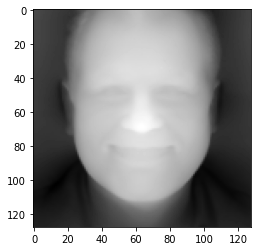

In [ ]:
import torch
input = torch.load('/content/input.pt')
out = torch.load('/content/gt.pt')
from matplotlib import pyplot as plt
inp = np.moveaxis(input.detach().cpu().numpy(), 0 , -1)
norm_inp = (inp+1)/2 # normalize from [-1, 1] to [0, 1]
plt.imsave("/content/input.png", norm_inp)
plt.imshow(out.detach().cpu().numpy(), cmap='gray')

In [ ]:
from midas.transforms import Resize, NormalizeImage, PrepareForNet
depth_path = '/content/drive/MyDrive/datasets/eg3d/depth128x128/seed0001.png'
gt_np = utils.read_image(depth_path)
r = Resize(width=512, height=512, resize_target=False)

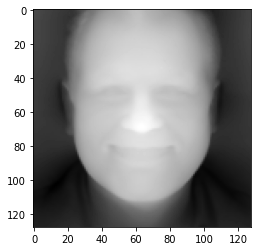

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure()
img = {'image': gt_np}
resized_np = r(img)
plt.imshow(gt_np[:, :, 2], cmap='gray')

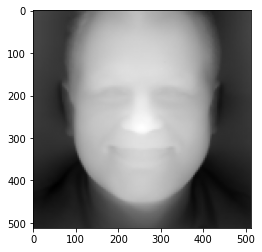

In [ ]:
resized_np['image']
plt.imshow(resized_np["image"])


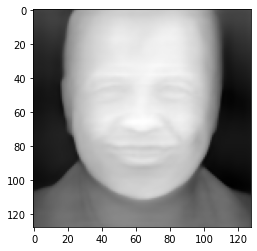

In [ ]:
downsample = Resize(width=128, height=128, resize_target=False)
double_res = downsample(resized_np)
plt.imshow(double_res["image"])

In [ ]:
#save 2 arrays as depth images
utils.write_depth('/content/gt_128', gt_np[:, :, 2], bits=1)
utils.write_depth('/content/gt_512', resized_np['image'][:, :, 2], bits=1)
utils.write_depth('/content/resized_128', double_res['image'][:, :, 2], bits=1)

In [ ]:
depthImage2mesh('/content/gt_128.png', save=True)

100%|██████████| 511/511 [00:19<00:00, 25.93it/s]


(tensor([[[0.0000, 0.0000, 0.4667],
          [0.0000, 0.0039, 0.4667],
          [0.0000, 0.0078, 0.4667],
          ...,
          [1.9961, 1.9883, 0.3490],
          [1.9961, 1.9922, 0.3569],
          [1.9961, 1.9961, 0.3725]]]), tensor([[[  1027,   1028,   1539],
          [  1540,   1539,   1028],
          [  1028,   1029,   1540],
          ...,
          [261630, 261631, 262142],
          [262143, 262142, 261631],
          [261631, 261632, 262143]]]), tensor([[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]))

In [ ]:
depthImage2mesh('/content/gt_512.png', save=True)

100%|██████████| 127/127 [00:01<00:00, 113.20it/s]


(tensor([[[0.0000, 0.0000, 0.4745],
          [0.0000, 0.0156, 0.4902],
          [0.0000, 0.0312, 0.4902],
          ...,
          [1.9844, 1.9531, 0.2784],
          [1.9844, 1.9688, 0.3020],
          [1.9844, 1.9844, 0.3412]]]), tensor([[[  259,   260,   387],
          [  388,   387,   260],
          [  260,   261,   388],
          ...,
          [16254, 16255, 16382],
          [16383, 16382, 16255],
          [16255, 16256, 16383]]]), tensor([[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]))

In [ ]:
depthImage2mesh('/content/resized_128.png', save=True)

100%|██████████| 127/127 [00:01<00:00, 112.45it/s]


(tensor([[[0.0000, 0.0000, 0.4353],
          [0.0000, 0.0156, 0.4353],
          [0.0000, 0.0312, 0.4431],
          ...,
          [1.9844, 1.9531, 0.7333],
          [1.9844, 1.9688, 0.7412],
          [1.9844, 1.9844, 0.7333]]]), tensor([[[  259,   260,   387],
          [  388,   387,   260],
          [  260,   261,   388],
          ...,
          [16254, 16255, 16382],
          [16383, 16382, 16255],
          [16255, 16256, 16383]]]), tensor([[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]))

In [ ]:
depthImage2mesh('/content/pred_128.png', save=True)

100%|██████████| 127/127 [00:01<00:00, 101.06it/s]


(tensor([[[ 0.0000,  0.0000,  0.3333],
          [ 0.0000,  0.0156,  0.4510],
          [ 0.0000,  0.0312,  0.5373],
          ...,
          [ 1.9844,  1.9531,  0.2706],
          [ 1.9844,  1.9688,  0.1529],
          [ 1.9844,  1.9844, -0.0431]]]), tensor([[[  259,   260,   387],
          [  388,   387,   260],
          [  260,   261,   388],
          ...,
          [16254, 16255, 16382],
          [16383, 16382, 16255],
          [16255, 16256, 16383]]]), tensor([[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]))

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_mesh('m2', vertices=verts, colors=colors, faces=faces)
writer.close()

In [ ]:
import os
import numpy as np
w = np.load(os.path.join(gt_data_path, 'seed0001.npy'))
print(w.shape)
print(w.dtype)
print(w[0])

(1, 14, 512)
float32
[[-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 ...
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]
 [-0.05591475 -0.02665274  0.28139046 ... -0.11796942 -0.17887309
  -0.12235566]]


In [ ]:
# Check val
val = np.load("/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/val.npy", allow_pickle=True)
val.item()['valX']

[['/content/drive/MyDrive/datasets/eg3d/images/seed0000.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0001.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0002.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0003.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0004.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0005.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0006.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0007.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0008.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0009.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0010.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0011.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0012.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0013.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0014.png'],
 ['/content/drive/MyDrive/datasets/eg3d/images/seed0015

In [ ]:
# Add 2 latent codes
l200 = np.load('/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/seed0200/out.npy')
l14 = np.load('/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/seed0014/out.npy')

lnew = (l200+l14)/2
retarget_path = '/content/drive/MyDrive/eg3d/experiments/latent_train10k_samples/retargetting_seed0014and0200'
np.save(file=os.path.join(retarget_path, 'out.npy'), arr=lnew)

In [ ]:
unique = []
dir = '/content/drive/MyDrive/datasets/prosopo_new/input/'
for filename in os.listdir(dir):
        if '(' not in filename: 
            unique.append(filename)
        else:
          fullpath = os.path.join(dir, filename)
          print("delete", filename)
          os.remove(filename)

delete 00416 (1).png
delete 00578 (1).png
delete 00291 (1).png
delete 00085 (1).png
delete 00550 (1).png
delete 00074 (1).png
delete 01997 (1).png
delete 01234 (1).png
delete 00210 (1).png
delete 01102 (2).png
delete 00204 (2).png
delete 01102 (1).png
delete 00204 (1).png
delete 01737 (1).png
delete 01736 (2).png
delete 01736 (1).png
delete 00951 (1).png
delete 01791 (1).png
delete 01237 (1).png
delete 00532 (1).png
delete 01426 (1).png
delete 00597 (1).png
delete 00944 (1).png
delete 01134 (1).png
delete 01485 (1).png
delete 00473 (1).png
delete 01050 (1).png
delete 01200 (1).png
delete 01224 (1).png
delete 00883 (1).png
delete 00930 (1).png
delete 01222 (1).png
delete 00254 (1).png
delete 00437 (1).png
delete 00464 (1).png
delete 00201 (1).png
delete 00875 (1).png
delete 00441 (1).png
delete 00621 (1).png
delete 00957 (1).png
delete 00547 (1).png
delete 00211 (2).png
delete 01223 (1).png
delete 00144 (1).png
delete 00897 (1).png
delete 01033 (1).png
delete 00211 (1).png
delete 00933 